The dataset and trained model folders should be **one level above** your notebook - that is, "../Datasets", "../trained_models" etc.  
   Suggested directory structure:  
   Root Folder/  
     - Datasets/  
     - Models/  
     - Src/  
       - scratch_2.ipynb  

In [1]:
import numpy as np
np.random.seed(0)
import torch
torch.manual_seed(0)
import random
random.seed(0)
from torch.utils.data import Dataset, DataLoader 
from torchvision.utils import save_image
from torch.autograd import Variable
import torch.nn as nn
from torch.nn import Module
import cv2
import os
import torchvision
import matplotlib.pyplot as plt
import matplotlib.image as mpig


In [3]:
def create_dir(dir_name):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

create_dir("../Models")
create_dir("../Outputs/AE")
create_dir("../Outputs/VAE")
create_dir("../Outputs/VGG")

## Filtering in 1D and 2D
### Implement a filter to remove low frequencies from the audio fileaudio.npy.  Plot the input and outputof your filter as line graphs. 

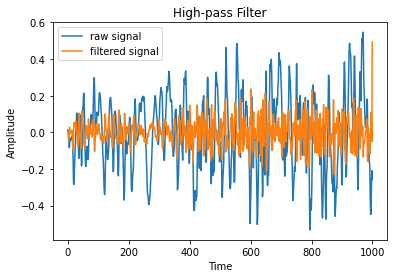

In [2]:
input_audio_filename = "../Datasets/Filtering/audio.npy"
    
def highpass_filter_audio(src):
    f = np.array([-1, 1])
    out = np.empty_like(src)
    f_length = f.size
    for i in range(0, src.size-(f_length-1)):
        src_slice = src[i:i+f_length]
        out[i] = src_slice.dot(f.T)
    return out
    return filtered_audio

input_audio = np.load(input_audio_filename)
filtered_audio = highpass_filter_audio(input_audio)

plt.plot(input_audio, label="raw signal")
plt.plot(filtered_audio, label="filtered signal")
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('High-pass Filter')
plt.legend()
plt.show()

### Implement a filter to find vertical edges in an image.  We provide a sample fileimage.pngfor testing. Apply your filter to this image and display the input and output of your filter. 

In [6]:
def convolve_3d(img, f): # made this into a function to be used for 1b and 2a
    filter_h, filter_w = f.shape
    kern = np.fliplr(np.flipud(f))
    img_h, img_w, img_c = img.shape
    padding = (img_h + 4, img_w + 4, img_c)
    img_pad = np.zeros(padding)
    half = 4//2
    img_pad[half:-half, half:-half, :] = img
    img_out = np.empty(img.shape)
    for i in range(img_w):
        for j in range(img_h):
            for k in range(3):
                sum = (
                    np.sum(kern * img_pad[j:j + filter_h, i:i + filter_w, k]))
                if sum > 255:
                    img_out[j, i, k] = 255
                elif sum < 0:
                    img_out[j, i, k] = 0
                else:
                    img_out[j, i, k] = sum
    img_out = img_out.astype(int)
    return img_out

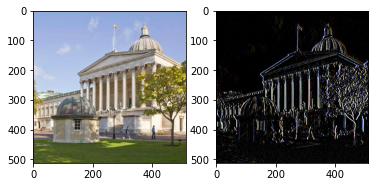

In [4]:
input_image_filename = "../Datasets/Filtering/image.png"

# LOAD input_image FROM input_image_filename

def detect_vertical_edges(image):
    v_edge_filter = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    filtered_image = convolve_3d(image,v_edge_filter)
    return filtered_image

input_image = (np.array(cv2.imread(input_image_filename)))[:, :, [2, 1, 0]]
filtered_image = detect_vertical_edges(input_image)

plt.axis("off")
plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.subplot(1, 2, 2)
plt.imshow(filtered_image)
plt.show()

## Denoising
### Implement denoise_gauss to denoise an image using a 5×5 Gaussian filter. 


In [7]:
def get_gaussian(n, sigma):
    g_filter = np.zeros((n, n), np.float32)
    m = n//2
    for i in range(-m, m+1):
        for j in range(-m, m+1):
            x1 = 2*np.pi*(sigma**2)
            x2 = np.exp(-(i**2 + j**2)/(2 * sigma**2))
            g_filter[i+m, j+m] = (1/x1)*x2
    return g_filter

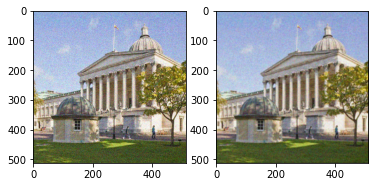

In [8]:
noisy_image_filename = "../Datasets/Filtering/noisy_image.png"

# LOAD noisy_image FROM noisy_image_filename

def denoise_gauss(image):
    gaussian_filter = get_gaussian(5, 1)
    denoised_image = convolve_3d(image, gaussian_filter)
    return denoised_image

noisy_image = (np.array(cv2.imread(noisy_image_filename))[:, :, [2, 1, 0]])
denoised_image = denoise_gauss(noisy_image)

plt.axis("off")
plt.subplot(1, 2, 1)
plt.imshow(noisy_image)
plt.subplot(1, 2, 2)
plt.imshow(denoised_image)
plt.show()

### Implement a pyramidal encoder-decoder to denoise an image.  

In [2]:
def save_img(label, output, clip, num_cols, rel_dir, epoch): #helper function to save and display images
    both = torch.cat((label[:clip],
                              output[:clip]))
    file_name = rel_dir.format(epoch)
    save_image(both.cpu(), file_name, nrow=num_cols)
    image = mpig.imread(file_name)
    image = image[:, :, [2, 1, 0]]
    plt.axis("off")
    plt.imshow(image)
    plt.show()

epoch [0/100], average loss:0.2456


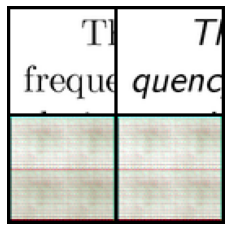

epoch [10/100], average loss:0.0465


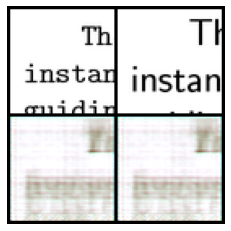

epoch [20/100], average loss:0.0359


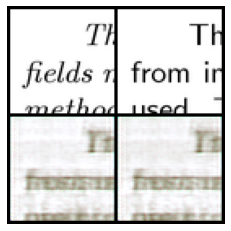

epoch [30/100], average loss:0.0285


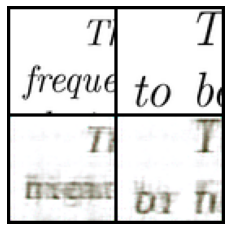

epoch [40/100], average loss:0.0196


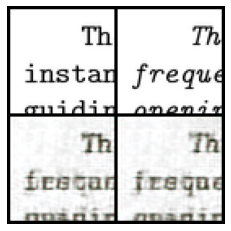

epoch [50/100], average loss:0.0089


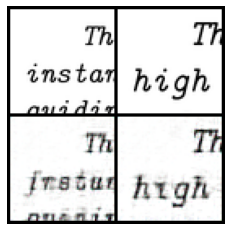

epoch [60/100], average loss:0.0057


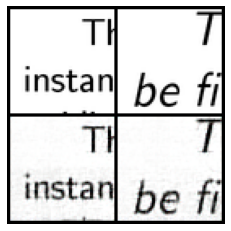

epoch [70/100], average loss:0.0030


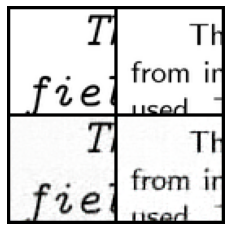

epoch [80/100], average loss:0.0052


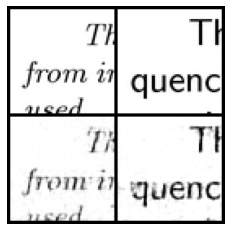

epoch [90/100], average loss:0.0018


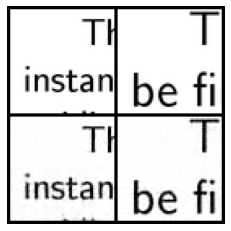

In [15]:
input_imgs_path = "../Datasets/Denoising/input_noisy_images"
cleaned_imgs_path = "../Datasets/Denoising/target_clean_images"

class DenoisingDB(Dataset):
    def __init__(self, path1, path2):
        image_names = os.listdir(path1)
        self.image_paths = [os.path.join(path1, name) for name in image_names]
        Y_names = os.listdir(path2)
        self.Y_paths = [os.path.join(path2, name) for name in Y_names]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):  # crops and normalizes the input and target images
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        img = img[0:64, 0:64]
        img = cv2.normalize(img, None, alpha=0, beta=1,
                            norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        Y_path = self.Y_paths[idx]
        out = cv2.imread(Y_path)
        out = out[0:64, 0:64]
        out = cv2.normalize(out, None, alpha=0, beta=1,
                            norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        return (img, out)
    
class TestingDB(Dataset):
    def __init__(self, path1):
        image_names = os.listdir(path1)
        self.image_paths = [os.path.join(path1, name) for name in image_names]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):  # crops and normalizes the input and target images
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        img = img[0:64, 0:64]
        img = cv2.normalize(img, None, alpha=0, beta=1,
                            norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        return img

class Encoder(Module):
  # IMPLEMENT THIS ENCODER CLASS
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
        )

    def forward(self,high_res_image):
        low_res_image = self.encoder(high_res_image)
        return low_res_image

class Decoder(Module):
  # IMPLEMENT THIS DECODER CLASS

    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(3, 3, kernel_size=3, padding=1)
        )

    def forward(self,low_res_image):
        denoised_image = self.decoder(low_res_image)
        return denoised_image
        
def loss_function(input,target):
    loss = criterion(input, target)
    return loss

epochs = 100 
learning_rate = 1e-3
batch_size = 2

docs_dataset = DenoisingDB(input_imgs_path, cleaned_imgs_path)
torch_train_docs = DataLoader(docs_dataset,shuffle=True,batch_size=batch_size,num_workers=0)  # YOU CAN CHOOSE YOUR BATCH SIZE


encoder = Encoder()
decoder = Decoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
            list(encoder.parameters())+list(decoder.parameters()), lr=learning_rate, weight_decay=1e-5) # USE THE TORCH API TO WRITE YOUR Stochastic Gradient Descent optimizer function here.

for ep in range(epochs):
    train_loss = 0
    for data in torch_train_docs:
        img = data[0]
        labels = data[1]

        img = img.permute(0, 3, 1, 2)
        labels = labels.permute(0, 3, 1, 2)
        
        # forward pass
        intermediate = encoder(img)
        output = decoder(intermediate)
        
        loss = loss_function(output, labels)
        train_loss += loss.item()

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    avg_loss = train_loss / len(torch_train_docs)
    if ep % 10 == 0:
        print('epoch [{}/{}], average loss:{:.4f}'.format(ep, epochs, avg_loss))
        save_img(labels,output, 5, 2, '../Outputs/AE/noisy{}.png', ep)
        
torch.save(encoder, "../Models/model_q2_encoder.pth")
torch.save(decoder, "../Models/model_q2_decoder.pth")

Gaussian blur works without any training so it can be performed relatively quickly. It accomplishes the general goal of denoising the image of small spots very nicely; however, large sources of noise (such as coffee stains and shadows due to crumpling) are still present in the output images becuase the filter is not learned to adjust for the task of remvoing these types of noise. There are is no infrastructure to divide the image into smaller pieces and apply individual processing, so certain features that would be visible in smaller resolutions are never discovered: because the same filter is applied to the input image, both the noisy regions that we wish to blur and the non-noisy regions that we wish to leave untouched are both denoised in the same way, so we loose data that a more complex system could have potentially reserved. In short, the Gaussian Blur is sufficient for detecting and removing pixel-wise sources of noise, but fails to fit to other examples that contain multi-pixel stretching noise. This means that the GB method is more brittle, and will have low success in generalising to new images that contain alternative types of noise.

On the other hand, the Autoencoder model performs the same task but produces output that is much closer to the desired behavior: the AE can recognize and remove both both small and large sources of noise. This is the result of a combination of multiple factors. Firstly, because the image's resolution is sequentially lowered, the model is able to discern otherwise overooked features, such as coffee stains and wrinkles, in the image. Secondly, the image is sequentially broken up into multiple channels, allowing the discovery of even more otherwise unobvious features. Consequentally, the model is able to become highly robust to variations in the type of noise present in the image and hence generalise to unseen examples much more successfully. Unlike the GB method, the model is able to discern that the text itself is the only important feature to extract from the input image, so it learns to disambiguate the text from the background. Unfortunately these advantageous come at the cost of time: because this is a supervised model, it requires a training period so that the kernels/filters can be learned to produce the most optimum combination. Once trained, however, these filters can be applied quickly (although still slower than the GB). 

## Auto-Encoder
### Implement a convolutional auto-encoder (AE). The loss between in and output should be L2.  You canmake use of all the convolution, pooling, back-propagation and build-in functionality of Pytorch here. 

In [3]:
class AutoEncoder(Module):
    # IMPLEMENT THIS AUTO-ENCODER CLASS
    def __init__(self,bottleneck_size):
        super(AutoEncoder, self).__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(3, bottleneck_size//4, 4, stride=2, padding=1),  # 32
            nn.ReLU(True),
            nn.Conv2d(bottleneck_size//4, bottleneck_size//2, 4, stride=2, padding=1),  # 16
            nn.ReLU(True),
            nn.Conv2d(bottleneck_size//2, bottleneck_size, 4, stride=2, padding=1),  # 8
            nn.ReLU(True),
        )
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(bottleneck_size, bottleneck_size//2, 4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(bottleneck_size//2, bottleneck_size//4, 4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(bottleneck_size//4, 3, 4, stride=2, padding=1),
            nn.Sigmoid()
        )
    
    def encoder(self,image):
        code = self.enc(image)
        return code
    
    def decoder(self,code):
        decode = self.dec(code)
        return decode
    
    def forward(self,image):
        intermediate = self.enc(image)
        decoded_image = self.dec(intermediate)
        return decoded_image

### Test it on the CelebA and MNIST dataset by encoding and decoding their first 5 samples. Compile results showing for each of the dataset and for each sample the input and the AE reconstruction,side-by-side. 

#### Dataloading Cell 

In [4]:
class CelebA(Dataset):
    def __init__(self, path):
        image_names = os.listdir(path)
        self.image_paths = [os.path.join(path, name) for name in image_names]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, (64, 64))
        img = cv2.normalize(img, None, alpha=0, beta=1,
                            norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        return img

    
class MNIST(Dataset):
    def __init__(self, path):
        image_names = os.listdir(path)
        self.image_paths = [os.path.join(path, name) for name in image_names]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, (64, 64))
        img = cv2.normalize(img, None, alpha=0, beta=1,
                            norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        return img

epochs = 5
batch_size = 2
learning_rate = 1e-3

celeba_train_data_path = "../Datasets/CelebA/train/"
celeba_train_dataset = CelebA(celeba_train_data_path)
torch_train_celeba = DataLoader(celeba_train_dataset,shuffle=True,batch_size=batch_size,num_workers=0)  # YOU CAN CHOOSE YOUR BATCH SIZE

celeba_validation_data_path = "../Datasets/CelebA/validation/"
celeba_validation_dataset = CelebA(celeba_validation_data_path)
torch_validation_celeba = DataLoader(celeba_validation_dataset,shuffle=True,batch_size=batch_size,num_workers=0)  # YOU CAN CHOOSE YOUR BATCH SIZE

mnist_train_data_path = "../Datasets/MNIST/train/"
mnist_train_dataset = MNIST(mnist_train_data_path)
torch_train_mnist = DataLoader(mnist_train_dataset,shuffle=True,batch_size=batch_size,num_workers=0)  # YOU CAN CHOOSE YOUR BATCH SIZE

mnist_validation_data_path = "../Datasets/MNIST/validation/"
mnist_validation_dataset = MNIST(mnist_validation_data_path)
torch_validation_mnist = DataLoader(mnist_validation_dataset,shuffle=True,batch_size=batch_size,num_workers=0)  # YOU CAN CHOOSE YOUR BATCH SIZE

#### Auto-Encoder training cell

epoch [1/5], average loss:0.0034


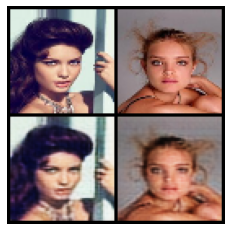

Validation set loss: 0.0016413094708696008
epoch [2/5], average loss:0.0014


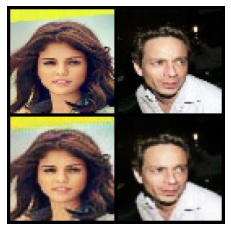

Validation set loss: 0.0011378490598872304
epoch [3/5], average loss:0.0011


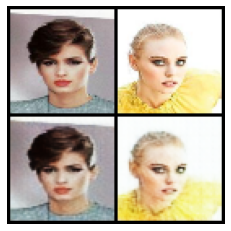

Validation set loss: 0.0010627026204019785
epoch [4/5], average loss:0.0010


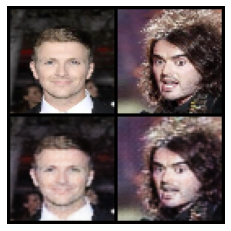

Validation set loss: 0.001415162580087781
epoch [5/5], average loss:0.0010


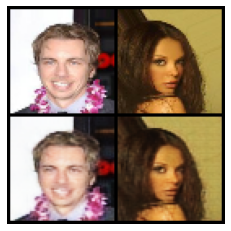

Validation set loss: 0.0009428613120689988


In [22]:
criterion = nn.MSELoss()

def reconstruction_loss(input,target):
    recon_loss = criterion(input, target)
    return recon_loss

mnist_bottleneck_size = 64 # CHOOSE YOUR BOTTLENECK SIZE. ONCE CHOSEN, USE THE SAME FOR ALL OF Q3 and Q4, for MNIST.
celeba_bottleneck_size = 64 # CHOOSE YOUR BOTTLENECK SIZE. ONCE CHOSEN, USE THE SAME FOR ALL OF Q3 and Q4, for CelebA

mnist_autoencoder = AutoEncoder(mnist_bottleneck_size)
celeba_autoencoder = AutoEncoder(celeba_bottleneck_size)
# IN THE TRAINING LOOPS BELOW, USE THE DEFINED NETWORK, LOSS FUNCTION AND OPTIMIZER.

mnist_optimizer = torch.optim.SGD(
    mnist_autoencoder.parameters(), lr=learning_rate)
celeba_optimizer = torch.optim.SGD(
    celeba_autoencoder.parameters(), lr=learning_rate)

for ep in range(epochs):
    train_loss = 0
    for data in torch_train_celeba:
        #         img = data[:, :, :, [2, 1, 0]]
        img = data.permute(0, 3, 1, 2)

        # forward pass
        output = celeba_autoencoder(img)
        loss = reconstruction_loss(output, img)
        train_loss += loss

        # backward pass
        celeba_optimizer.zero_grad()
        loss.backward()
        celeba_optimizer.step()
    avg_loss = train_loss / len(torch_train_celeba)

    print('epoch [{}/{}], average loss:{:.4f}'.format(ep + 1, epochs, avg_loss))
    save_img(img, output, 2, 2,'../Outputs/AE/celeba_train{}.png', ep)

    celeba_test_loss = 0
    for data in torch_validation_celeba:
        #         img = data[:, :, :, [2, 1, 0]]
        img = data.permute(0, 3, 1, 2)
        output = celeba_autoencoder(img)
        loss = reconstruction_loss(output, img)
        celeba_test_loss += loss
    avg_loss = celeba_test_loss / len(torch_validation_celeba)
    print('Validation set loss: {}'.format(avg_loss))

torch.save(celeba_autoencoder, "../Models/celeba_AE.pth")

epoch [0/5], average loss:0.1014


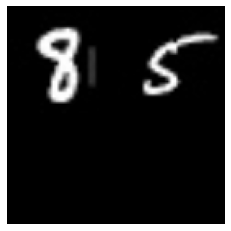

Validation set loss: 0.10024024546146393
epoch [1/5], average loss:0.1013


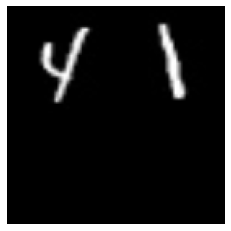

Validation set loss: 0.10024019330739975
epoch [2/5], average loss:0.1013


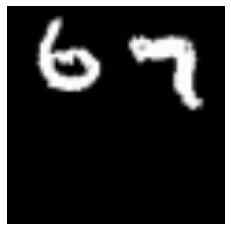

Validation set loss: 0.10024020075798035
epoch [3/5], average loss:0.0838


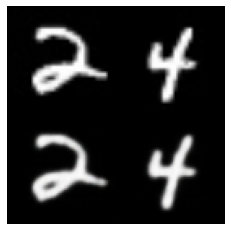

Validation set loss: 0.0007699406705796719
epoch [4/5], average loss:0.0004


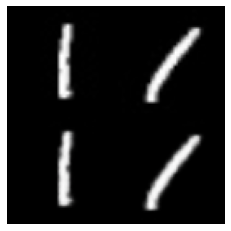

Validation set loss: 0.00021158962044864893


In [23]:
for ep in range(epochs):
    train_loss = 0
    for data in torch_train_mnist:
#         img = data[:, :, :, [2, 1, 0]]
        img = data.permute(0, 3, 1, 2)
        
        # forward pass
        output = mnist_autoencoder(img)
        loss = reconstruction_loss(output, img)
        train_loss += loss
        
        # backward pass
        mnist_optimizer.zero_grad()
        loss.backward()
        mnist_optimizer.step()
        
    avg_loss = train_loss / len(torch_train_mnist)
    
    print('epoch [{}/{}], average loss:{:.4f}'.format(ep, epochs, avg_loss))
    save_img(img,output, 2, 2,'../Outputs/AE/mnist_train{}.png', ep)

    mnist_test_loss = 0
    for data in torch_validation_mnist:
#         img = data[:, :, :, [2, 1, 0]]
        img = data.permute(0, 3, 1, 2)
        output = mnist_autoencoder(img)
        loss = reconstruction_loss(output, img)
        mnist_test_loss += loss
    avg_loss = mnist_test_loss / len(torch_validation_mnist)
    print('Validation set loss: {}'.format(avg_loss))

#### Auto-Encoder testing cell

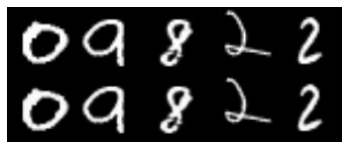

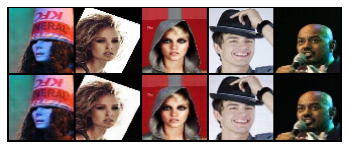

In [38]:
mnist_random_images = torch.from_numpy(np.array(random.sample(list(mnist_validation_dataset),5)))
celeba_random_images = torch.from_numpy(np.array(random.sample(list(celeba_validation_dataset),5)))

mnist_random_images = mnist_random_images.permute(0, 3, 1, 2)
celeba_random_images = celeba_random_images.permute(0, 3, 1, 2)

output_mnist = mnist_autoencoder(mnist_random_images)
output_celeba = celeba_autoencoder(celeba_random_images)

temp = "../Outputs/AE/mnist_test{}.png"
save_img(mnist_random_images, output_mnist, 5, 5, temp, 0)


temp = "../Outputs/AE/celeba_test{}.png"
save_img(celeba_random_images, output_celeba, 5, 5, temp, 0)

## Variational AutoEncoder (VAE)

### Add the reparametrization trick to turn the AE into a variational auto-encoder (VAE) 

In [18]:
class VAE(AutoEncoder):
    # IMPLEMENT THIS VAE CLASS
    def __init__(self,bottleneck_size):
        super(VAE, self).__init__(bottleneck_size)
        self.input_dim = 64
        self.latent_size = 256
        self.bottleneck_size = bottleneck_size

        self.enc = nn.Sequential(
            nn.Conv2d(3, self.bottleneck_size//4, 4, stride=2, padding=1),  # 32
            nn.ReLU(),
            nn.Conv2d(self.bottleneck_size//4, self.bottleneck_size //
                      2, 4, stride=2, padding=1),  # 16
            nn.ReLU(),
            nn.Conv2d(self.bottleneck_size//2, self.bottleneck_size,
                      4, stride=2, padding=1),  # 8
            nn.ReLU(),
        )
        self.mu = nn.Sequential(
            nn.Linear(self.bottleneck_size * self.input_dim//8 * self.input_dim//8, self.latent_size),
            nn.LeakyReLU(),
            nn.Dropout(0.2)
        )
        self.log_var = nn.Sequential(
            nn.Linear(self.bottleneck_size * self.input_dim//8 * self.input_dim//8, self.latent_size),
            nn.LeakyReLU(),
            nn.Dropout(0.2)
        )
        self.dec_fc = nn.Sequential(
            nn.Linear(self.latent_size, self.bottleneck_size * self.input_dim//8 * self.input_dim//8),
            nn.ReLU(),
        )
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(
                self.bottleneck_size, self.bottleneck_size//2, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(self.bottleneck_size//2,
                               self.bottleneck_size//4, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(self.bottleneck_size//4, 3, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encoder(self,image):
        out = self.enc(image.clone())
        self.out_shape = out.size()
        out = out.view(self.out_shape[0], -1)
        mu, log_var = self.mu(out), self.log_var(out)
        z = self.reparametrization_trick(mu, log_var)
        return z, mu, log_var
    
    def decoder(self, image):
        batch_size, latent_size = image.size()
        z1 = self.dec_fc(image)
        training_batch_size, bn_size, out_h, out_w  = self.out_shape
        z2 = z1.clone().view(batch_size, bn_size, out_h, out_w)
        decoded_image = self.dec(z2)
        return decoded_image

    def reparametrization_trick(self,mu,logvar):
        std = logvar.mul(0.5).exp_()
        esp = Variable(torch.randn(*mu.size()))
        z = mu + std * esp
        return z
    
    def forward(self,image):
        z0, mu, log_var = self.encoder(image)
        decoded_image = self.decoder(z0)
        return decoded_image, mu, log_var

### Test it on the CelebA and MNIST dataset by generating 5 samples of each to be shown in no morethan half a page.

#### VAE training cell

In [46]:
epochs = int(5)
learning_rate = 1e-3

epoch [1/5], loss:6799.3038


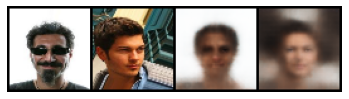

Validation set loss: 13461.2890625
epoch [2/5], loss:6699.9706


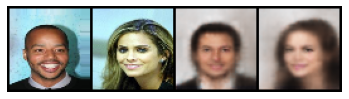

Validation set loss: 13392.3388671875
epoch [3/5], loss:6677.2037


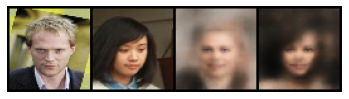

Validation set loss: 13347.4052734375
epoch [4/5], loss:6663.6266


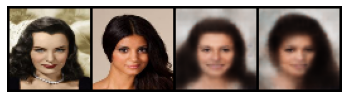

Validation set loss: 13341.8017578125
epoch [5/5], loss:6654.0984


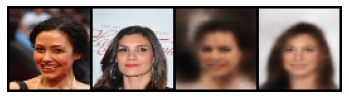

Validation set loss: 13370.6142578125


In [22]:
# IN THE TRAINING LOOPS BELOW, USE THE DEFINED NETWORK, LOSS FUNCTION AND OPTIMIZER.

criterion = nn.BCELoss(reduction='sum')

def kl_divergence_loss(mu,logvar):
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return kl_loss

def reconstruction_loss(input,target):
    recon_loss = criterion(input, target)
    return recon_loss


mnist_bottleneck_size = 64 # CHOOSE YOUR BOTTLENECK SIZE. ONCE CHOSEN, USE THE SAME FOR ALL OF Q3 and Q4, for MNIST.
celeba_bottleneck_size = 64 # CHOOSE YOUR BOTTLENECK SIZE. ONCE CHOSEN, USE THE SAME FOR ALL OF Q3 and Q4, for CelebA
latent_size = 256

mnist_vautoencoder = VAE(mnist_bottleneck_size)
celeba_vautoencoder = VAE(celeba_bottleneck_size)

mnist_optimizer = torch.optim.SGD(mnist_vautoencoder.parameters(), lr=learning_rate) 
celeba_optimizer = torch.optim.SGD(celeba_vautoencoder.parameters(), lr=learning_rate) 
# IN THE TRAINING LOOPS BELOW, USE THE DEFINED NETWORK, LOSS FUNCTION AND OPTIMIZER.
input_dim = 0

for ep in range(epochs):
    running_loss = 0.0
    for data in torch_train_celeba:
        img = data.permute(0, 3, 1, 2)
        
        # forward pass
        output, mu, logvar = celeba_vautoencoder(img)
        bce_loss = reconstruction_loss(output, img)
        kld_loss = kl_divergence_loss(mu, logvar)
        loss = bce_loss + kld_loss
        running_loss += loss.item()

        # backward pass
        celeba_optimizer.zero_grad()
        loss.backward()
        celeba_optimizer.step()
    
    val_loss = running_loss/len(torch_train_celeba.dataset)
    print('epoch [{}/{}], loss:{:.4f}'.format(ep+1, epochs, val_loss))
    save_img(img, output, 5, 5, '../Outputs/VAE/celeba_train{}.png', ep)
    
    celeba_test_loss = 0
    for data in torch_validation_celeba:
        img = data.permute(0, 3, 1, 2)
        output, mu, logvar = celeba_vautoencoder(img)
        bce_loss = reconstruction_loss(output, img)
        kld_loss = kl_divergence_loss(mu, logvar)
        loss = bce_loss + kld_loss
        celeba_test_loss += loss
    avg_loss = celeba_test_loss / len(torch_validation_celeba)
    print('Validation set loss: {}'.format(avg_loss))

torch.save(celeba_vautoencoder, "../Models/celeba_VAE.pth")

epoch [1/0.001], loss:1946.0085


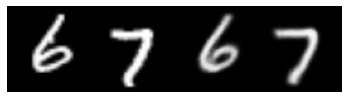

Validation set loss: 3143.85302734375
epoch [2/0.001], loss:1789.2397


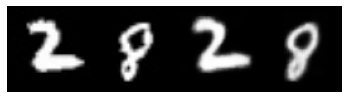

Validation set loss: 3079.1572265625
epoch [3/0.001], loss:1757.8110


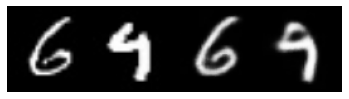

Validation set loss: 3027.740478515625
epoch [4/0.001], loss:1740.9980


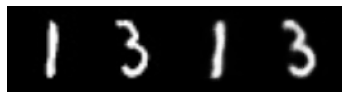

Validation set loss: 2998.248046875
epoch [5/0.001], loss:1729.1884


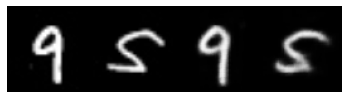

Validation set loss: 2999.65283203125


In [15]:
for ep in range(5):
    running_loss = 0.0
    for data in torch_train_mnist:
        img = data.permute(0, 3, 1, 2)

        # forward pass
        output, mu, logvar = mnist_vautoencoder(img)
        bce_loss = reconstruction_loss(output, img)
        kld_loss = kl_divergence_loss(mu, logvar)
        loss = bce_loss + kld_loss
        running_loss += loss.item()

        # backward pass
        mnist_optimizer.zero_grad()
        loss.backward()
        mnist_optimizer.step()
    
    val_loss = running_loss/len(torch_train_mnist.dataset)
    print('epoch [{}/{}], loss:{:.4f}'.format(ep+1, epochs, val_loss))
    save_img(img, output, 5, 5,'../Outputs/VAE/mnist_train{}.png', ep)
    
    celeba_test_loss = 0
    for data in torch_validation_mnist:
        img = data.permute(0, 3, 1, 2)
        output, mu, logvar = mnist_vautoencoder(img)
        bce_loss = reconstruction_loss(output, img)
        kld_loss = kl_divergence_loss(mu, logvar)
        loss = bce_loss + kld_loss
        celeba_test_loss += loss
    avg_loss = celeba_test_loss / len(torch_validation_celeba)
    print('Validation set loss: {}'.format(avg_loss))

torch.save(mnist_vautoencoder, "../Models/mnist_VAE.pth")


#### VAE testing cell

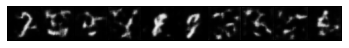

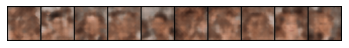

In [8]:
mnist_vautoencoder = torch.load("../Models/model_q4_mnist.pth")
mnist_vautoencoder.eval()

number_of_samples = 10

random_mnist_images = torch.FloatTensor([])

### MNIST sample generation
for i in range(number_of_samples):
    random_normal_code = torch.randn(1, mnist_vautoencoder.latent_size)
    img_out = mnist_vautoencoder.decoder(random_normal_code)
    random_mnist_images = torch.cat((random_mnist_images, img_out))
    
temp = "../Outputs/VAE/mnist_random.png"
save_image(random_mnist_images.cpu(), temp, nrow=10)

image = mpig.imread(temp)
image = image[:, :, [2, 1, 0]]
plt.axis("off")
plt.imshow(image)
plt.show()

celeba_vautoencoder = torch.load("../Models/model_q4_celeba.pth")
celeba_vautoencoder.eval()

random_celeba_images = torch.FloatTensor([])

### CelebA sample generation
for i in range(number_of_samples):
    random_normal_code = torch.randn(1,celeba_vautoencoder.latent_size)
    img_out = celeba_vautoencoder.decoder(random_normal_code)
    random_celeba_images = torch.cat((random_celeba_images, img_out))
    
temp = "../Outputs/VAE/celeba_random.png"
save_image(random_celeba_images.cpu(), temp, nrow=10)

image = mpig.imread(temp)
image = image[:, :, [2, 1, 0]]
plt.axis("off")
plt.imshow(image)
plt.show()


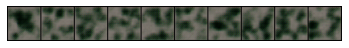

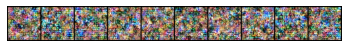

In [9]:
number_of_samples = 10

mnist_autoencoder = torch.load("../Models/model_q3_mnist.pth")
mnist_autoencoder.eval()

random_mnist_images = torch.FloatTensor([])

### MNIST sample generation
for i in range(number_of_samples):
    random_normal_code = torch.randn(1, 64*64)
    z2 = random_normal_code.view(1, 64, 8, 8)
    out = mnist_autoencoder.decoder(z2)
    random_mnist_images = torch.cat((random_mnist_images, out))
    
temp = "../Outputs/AE/mnist_random.png"
save_image(random_mnist_images.cpu(), temp, nrow=10)

image = mpig.imread(temp)
image = image[:, :, [2, 1, 0]]
plt.axis("off")
plt.imshow(image)
plt.show()
    
celeba_autoencoder = torch.load("../Models/model_q3_celeba.pth")
celeba_autoencoder.eval()

random_celeba_images = torch.FloatTensor([])

### CelebA sample generation
for i in range(number_of_samples):
    random_normal_code = torch.randn(1, 64*64)
    z2 = random_normal_code.view(1, 64, 8, 8)
    out = celeba_autoencoder.decoder(z2)
    random_celeba_images = torch.cat((random_celeba_images, out))
    
temp = "../Outputs/AE/celeba_random.png"
save_image(random_celeba_images.cpu(), temp, nrow=10)

image = mpig.imread(temp)
image = image[:, :, [2, 1, 0]]
plt.axis("off")
plt.imshow(image)
plt.show()

The AE cannot generate images from a randomly generated code because it requires the incoming input channels to be manipulated by the previous encoding layers and encodes them as a single point but because the VAE has intermediary Linear layers to learn a a distribution over the latent space, any randomly generated random variable can be decoded to construct intermediary faces. 

### Modify your VAE training to use this VGG Perceptual loss, instead of reconstruction loss.  For this loss,you can use the activation from any of thenlayers of VGG - you can choose your list of VGG layers to use, to generate the best results. 

#### VGG Perceptual Loss definition

In [20]:
class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        vgg = torchvision.models.vgg16(pretrained=True)
        
        blocks.append(vgg.features[:4].eval()) 
        blocks.append(vgg.features[4:9].eval()) 
        blocks.append(vgg.features[9:16].eval())
        blocks.append(vgg.features[16:23].eval())

        for bl in blocks:
            for p in bl:
                p.requires_grad = False
                
        self.blocks = torch.nn.ModuleList(blocks)
        self.transform = torch.nn.functional.interpolate
        self.mean = torch.nn.Parameter(torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1))
        self.std = torch.nn.Parameter(torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1))

    def forward(self, input, target):
        input = (input-self.mean) / self.std
        target = (target-self.mean) / self.std
        
        input = self.transform(input, mode='bilinear', size=(224, 224), align_corners=False)
        target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)
        
        vgg_perceptual_loss = 0.0
        
        x = input
        y = target
        for block in self.blocks:
            x = block(x)
            y = block(y)
            vgg_perceptual_loss += torch.nn.functional.mse_loss(x, y)
        return vgg_perceptual_loss

#### Training Cell with VGG Loss

In [8]:
# IN THE TRAINING LOOPS BELOW, USE THE DEFINED NETWORK, LOSS FUNCTION AND OPTIMIZER.

def kl_divergence_loss(mu,logvar):
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return kl_loss

def reconstruction_loss(input,target):
    recon_loss = criterion(input, target)
    return recon_loss

epochs = 5
learning_rate = 1e-4

mnist_bottleneck_size = 64 # CHOOSE YOUR BOTTLENECK SIZE. ONCE CHOSEN, USE THE SAME FOR ALL OF Q3 and Q4, for MNIST.
celeba_bottleneck_size = 64 # CHOOSE YOUR BOTTLENECK SIZE. ONCE CHOSEN, USE THE SAME FOR ALL OF Q3 and Q4, for CelebA

mnist_vggautoencoder = VAE(mnist_bottleneck_size)
celeba_vggautoencoder = VAE(celeba_bottleneck_size)

mnist_optimizer = torch.optim.Adam(mnist_vggautoencoder.parameters(), lr=learning_rate) 
celeba_optimizer = torch.optim.Adam(celeba_vggautoencoder.parameters(), lr=learning_rate) 
# IN THE TRAINING LOOPS BELOW, USE THE DEFINED NETWORK, LOSS FUNCTION AND OPTIMIZER.

vgg_loss = VGGPerceptualLoss()

for ep in range(epochs):
    running_loss = 0.0
    index = 0
    for data in torch_train_celeba:
        img = data.permute(0, 3, 1, 2)
        print("{}/{}".format(index, len(torch_train_celeba.dataset)//batch_size))

        # forward pass
        output, mu, logvar = celeba_vggautoencoder(img)
        perc_loss = vgg_loss.forward(output, img)
        kld_loss = kl_divergence_loss(mu, logvar)
        loss = perc_loss + kld_loss
        running_loss += loss.item()

        # backward pass
        celeba_optimizer.zero_grad()
        loss.backward()
        celeba_optimizer.step()
        index += 1
    val_loss = running_loss/len(torch_train_celeba.dataset)
    save_img(img, output, 5, 5, '../Outputs/VGG/celeba_train{}.png', ep)
    
    celeba_test_loss = 0
    for data in torch_validation_celeba:
        img = data.permute(0, 3, 1, 2)
        output, mu, logvar = celeba_vggautoencoder(img)
        perc_loss = vgg_loss.forward(output, img)
        kld_loss = kl_divergence_loss(mu, logvar)
        loss = perc_loss + kld_loss
        celeba_test_loss += loss
    avg_loss = celeba_test_loss / len(torch_validation_celeba)

torch.save(celeba_vggautoencoder, "../Models/model_q4_vgg_celeba.pth")

0/66360


In [ ]:

vgg_loss = VGGPerceptualLoss()

for ep in range(epochs):
    running_loss = 0.0
    for data in torch_train_mnist:
        img = data.permute(0, 3, 1, 2)

        # forward pass
        output, mu, logvar = mnist_vggautoencoder(img)
        perc_loss = vgg_loss.forward(output, img)
        kld_loss = kl_divergence_loss(mu, logvar)
        loss = perc_loss + kld_loss
        running_loss += loss.item()

        # backward pass
        mnist_optimizer.zero_grad()
        loss.backward()
        mnist_optimizer.step()
    
    val_loss = running_loss/len(torch_train_mnist.dataset)
    save_img(img, output, 5, 5,'../Outputs/VGG/mnist_train{}.png', ep)
    
    celeba_test_loss = 0
    for data in torch_validation_mnist:
        img = data.permute(0, 3, 1, 2)
        output, mu, logvar = mnist_vggautoencoder(img)
        bce_loss = reconstruction_loss(output, img)
        kld_loss = kl_divergence_loss(mu, logvar)
        loss = bce_loss + kld_loss
        celeba_test_loss += loss
    avg_loss = celeba_test_loss / len(torch_validation_celeba)

torch.save(mnist_vggautoencoder, "../Models/model_q4_vgg_mnist.pth")

#### Testing Cell for VAE with VGG Perceptual Loss

In [ ]:
number_of_samples = 10

random_mnist_images = torch.FloatTensor([])

### MNIST sample generation
for i in range(number_of_samples):
    random_normal_code = torch.randn(1, mnist_vautoencoder.latent_size)
    img_out = mnist_vggautoencoder.decoder(random_normal_code)
    random_mnist_images = torch.cat((random_mnist_images, img_out))
    
temp = "../Outputs/VGG/mnist_random.png"
save_image(random_mnist_images.cpu(), temp, nrow=10)

image = mpig.imread(temp)
image = image[:, :, [2, 1, 0]]
plt.axis("off")
plt.imshow(image)
plt.show()

celeba_vggautoencoder = torch.load("../Models/model_q4_vgg_celeba.pth")
celeba_vggautoencoder.eval()


random_celeba_images = torch.FloatTensor([])

### CelebA sample generation
for i in range(number_of_samples):
    random_normal_code = torch.randn(1,celeba_vautoencoder.latent_size)
    img_out = celeba_vggautoencoder.decoder(random_normal_code)
    random_celeba_images = torch.cat((random_celeba_images, img_out))
    
temp = "../Outputs/VGG/celeba_random.png"
save_image(random_celeba_images.cpu(), temp, nrow=10)

image = mpig.imread(temp)
image = image[:, :, [2, 1, 0]]
plt.axis("off")
plt.imshow(image)
plt.show()